# Predicting Uncertainty

Using the 29 models produced in `4c_Uncertainty_LGBM_model.ipynb`, we will generate an ensemble of 29 predictions. From this ensemble we will produce an uncertainty envelope, and a median prediction.


In [ ]:
import sys
import os
import xarray as xr
import numpy as np
import pandas as pd
from joblib import load
from odc.geo.geobox import zoom_out
from odc.algo import xr_reproject
from datacube.utils.dask import start_local_dask
from odc.geo.xr import assign_crs
import odc.geo.xr
# from dask.distributed import Client,Scheduler
# from dask_jobqueue import SLURMCluster

sys.path.append('/g/data/os22/chad_tmp/NEE_modelling/')
from collect_prediction_data import round_coords#, collect_prediction_data, 

sys.path.append('/g/data/os22/chad_tmp/dea-notebooks/Tools/')
from dea_tools.classification import predict_xr, HiddenPrints

In [ ]:
# cluster = SLURMCluster(processes=2, cores=2, memory="47GB", walltime='02:00:00')
# client = Client(cluster)
# cluster.scale(cores=18)

client = start_local_dask(mem_safety_margin='2Gb')

In [ ]:
client

## Analysis Parameters

In [ ]:
var = 'NEE'
results_name='NEE_2003_2021_5km_LGBM_'
results_path = '/g/data/os22/chad_tmp/NEE_modelling/results/predictions_uncertainty/'
models_folder = '/g/data/os22/chad_tmp/NEE_modelling/results/models_uncertainty/'

mask_path = '/g/data/os22/chad_tmp/NEE_modelling/data/1km/mask_1km_monthly_2003_2021.nc'

t1, t2='2003','2021'
rescale=False

## Get paths to models

In [ ]:
model_list = [file for file in os.listdir(models_folder) if file.endswith(".joblib")]

## Open predictor data

In [ ]:
data = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/results/prediction_data/data_5km.nc')
mask = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/results/prediction_data/mask_5km.nc')

In [ ]:
# #open data
# data = collect_prediction_data(time_start=t1,
#                              time_end=t2,
#                              verbose=False,
#                              export=False
#                              )

# #open mask
# mask = xr.open_dataarray(mask_path, chunks=dict(x=750, y=750, time=1))

# data

In [ ]:
# mask = data[['vpd', 'SOC', 'NDWI', 'LST', 'tree_cover', 'FPAR']].to_array().isnull().any('variable')
# mask.compute().to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/1km/mask_1km_monthly_2003_2021.nc')

### Optionally rescale datasets to 5km

In [ ]:
# if rescale: 
#     gbox_5km = zoom_out(data.odc.geobox, 5)
#     data.attrs['nodata'] = np.nan
#     data = xr_reproject(data, geobox=gbox_5km.compat, resampling='average')
#     mask = xr_reproject(mask, geobox=gbox_5km.compat, resampling='mode')

#     #make sure the coords aren't too precise
#     data = round_coords(data)
#     mask = round_coords(mask)
#     data = data.rename({'latitude':'y', 'longitude':'x'}) #this helps with predict_xr
#     mask = mask.rename({'latitude':'y', 'longitude':'x'}) 

#     #rechunk arrays
#     # data = data.chunk(chunks=dict(x=1000, y=1000, time=1))
#     mask = mask.chunk(chunks=dict(x=1000, y=1000, time=1))

In [ ]:
# data = data.compute()
# mask = mask.compute()
# data.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/results/prediction_data/data_5km.nc')
# mask.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/results/prediction_data/mask_5km.nc')

### Check training and prediction variable order

In [ ]:
train_vars = list(pd.read_csv('/g/data/os22/chad_tmp/NEE_modelling/results/variables.txt'))[0:-1]
train_vars=[i[:-3] for i in train_vars]

data = data[train_vars]

if train_vars == list(data.data_vars):
    print('All good')
else:
    raise ValueError('Variables dont match')

### Predict each time-step seperately

- TO DO: fix timesteps that come back from `predict_xr`

In [ ]:
import warnings
warnings.filterwarnings("ignore")


# Loop through the 29 models
for m in model_list:
    name = m[9:14]
    
    if os.path.exists(results_path+results_name+name+'.nc'):
        print('skipping model '+name)
        continue
    
    print('Model: ', name)
    
    model = load(models_folder+m).set_params(n_jobs=1)
    
    results = []
    i=0
    #loop through the time-steps
    for i in range(0, len(data.time)): 
        print("  {:03}/{:03}\r".format(i + 1, len(range(0, len(data.time)))), end="")

        with HiddenPrints():
            predicted = predict_xr(model,
                                data.isel(time=i),
                                proba=False,
                                clean=True,
                                  ).compute()

        predicted = predicted.Predictions.where(~mask.isel(time=i).compute())
        predicted['time'] = data.isel(time=i).time.values
        results.append(predicted.astype('float32'))
        i+=1 
        
    ds = xr.concat(results, dim='time').sortby('time').rename(var).astype('float32')

    mask1 = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/1km/Landcover_1km_monthly_2002_2021.nc').isel(time=0)
    mask1 = (~np.isnan(mask1)).astype(np.int8)

    if rescale:
        mask1 = xr_reproject(mask1, geobox=gbox_5km.compat, resampling='mode')
        mask1=round_coords(mask1)

    else:
        mask1 = xr_reproject(mask1, geobox=data.odc.geobox.compat, resampling='mode')
        mask1=round_coords(mask1)


    mask1 = mask1.rename({'latitude':'y', 'longitude':'x'})
    ds = ds.where(~mask).astype('float32')

    #save results
    ds.to_netcdf(results_path+results_name+name+'.nc')
    
    

## Combine all the predictions

Ran 29 predictions, now its time to open and plot all of them?

Then we extract the interquartile range

Save as a netcdf to faciliate quick plotting later

In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# !rm -r -f /g/data/os22/chad_tmp/NEE_modelling/results/predictions_uncertainty/.ipynb_checkpoints

In [2]:
base = '/g/data/os22/chad_tmp/NEE_modelling/results/predictions_uncertainty/'
files = os.listdir(base)

In [3]:
pred_filepaths = [base+i for i in files]

### plot all results

In [ ]:
fig,ax = plt.subplots(1,1, figsize=(15, 5))
for pred in pred_filepaths:
    ds=xr.open_dataarray(pred)
    ds.sum(['x','y']).plot(ax=ax, alpha=0.25, c='lightskyblue', label=pred[-8:-3])

ds = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/NEE_2003_2021_5km_LGBM.nc')
ds.sum(['x','y']).plot(ax=ax, c='darkblue')
plt.axhline(0, c='grey', linestyle='--')
# ax.legend()

### Find interquantile range

In [4]:
arrs=[]
for pred in pred_filepaths:
    ds=xr.open_dataarray(pred)
    arrs.append(ds.rename(pred[-8:-3]))

In [5]:
ds = xr.merge(arrs)
ds = ds.to_array()

In [6]:
import sys
sys.path.append('/g/data/os22/chad_tmp/NEE_modelling/')
from _percentile import xr_quantile

In [7]:
ds = xr_quantile(ds, quantiles=[0.25,0.75], nodata=np.nan)

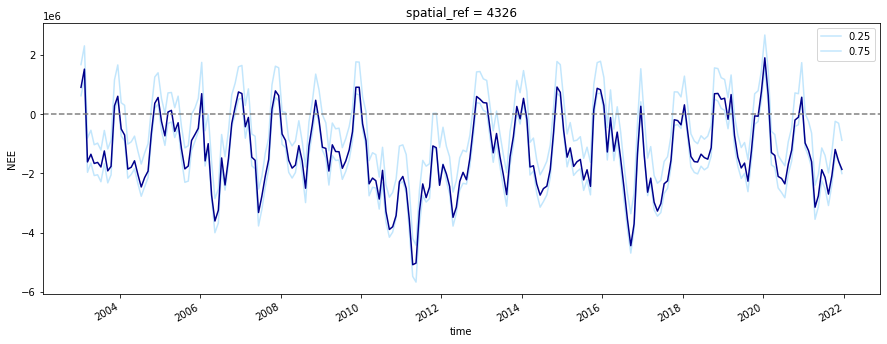

In [9]:
fig,ax = plt.subplots(1,1, figsize=(15, 5))
ds.band.sel(quantile=0.25).sum(['x','y']).plot(ax=ax, alpha=0.5, c='lightskyblue', label='0.25')
ds.band.sel(quantile=0.75).sum(['x','y']).plot(ax=ax, alpha=0.5, c='lightskyblue', label='0.75')

da = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/NEE_2003_2021_5km_LGBM.nc')
da.sum(['x','y']).plot(ax=ax, c='darkblue')
plt.axhline(0, c='grey', linestyle='--')
ax.legend()

In [16]:
ds = ds.rename({'band':'NEE_quantiles'}).to_array().squeeze().drop('variable')
ds.attrs['nodata']=np.nan

In [23]:
ds.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/NEE_2003_2021_5km_LGBM_quantiles.nc')x